In [1]:
!pip install --quiet quandl plotly git+https://github.com/ethho/memoize.git lmfit

In [8]:
import json
import re
import os
from glob import glob
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
from joblib import Parallel, delayed
import functools
import multiprocessing
from multiprocessing import Pool
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm, probplot
import quandl
import plotly.express as px
import plotly.graph_objects as go
from memoize.dataframe import memoize_df
from lmfit.models import SkewedGaussianModel

%matplotlib inline
# pd.options.display.float_format = '{:,.4f}'.format

DARK_MODE = False
if DARK_MODE:
    plt.style.use('dark_background')
    plotly_template = 'plotly_dark'
else:
    plt.style.use('ggplot')
    plotly_template = 'ggplot2'

# Fetch Data

First, let's set our time indices. We choose to trade weekly on Wednesdays, and skip the week if the Wednesday falls on a holiday.

In [ ]:
start_date = '1990-01-01'
end_date = '2022-12-16'

daily_idx = pd.date_range(start_date, end_date)
first_wed = get_next_day_of_week(start_date, 2)
wed_idx_w_holidays = pd.date_range(first_wed, end_date, freq='7D')
assert all(date.day_of_week == 2 for date in wed_idx_w_holidays)

wed_idx = [
    date for date in wed_idx_w_holidays
    if date not in pd.to_datetime([
        # Remove Wednesdays that fall on holidays
        '2012-12-26', '2013-12-25', '2014-01-01', '2018-12-26',
        '2019-12-25', '2020-01-01',
    ])
]
assert len(wed_idx_w_holidays) > len(wed_idx)

In [4]:
uszcb = pd.read_csv('./data/uszcb.csv', index_col=0)
uszcb.index = pd.to_datetime(uszcb.index)
uszcb.sort_index(inplace=True)
uszcb

,4_zcb,13_zcb,26_zcb,52_zcb,104_zcb,156_zcb,260_zcb,364_zcb,520_zcb,1040_zcb,...,13_val,26_val,52_val,104_val,156_val,260_val,364_val,520_val,1040_val,1560_val
date,,,,,,,,,,,,,,,,,,,,,
1990-01-03,NaN,0.0789,0.0794,0.0785,0.077803,0.078023,0.077535,0.079001,0.078211,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-10,NaN,0.0775,0.0778,0.0777,0.077546,0.077966,0.077573,0.078546,0.078849,NaN,...,NaN,1.085144,1.084248,1.082411,1.080423,1.076745,1.075912,1.052846,NaN,NaN
1990-01-17,NaN,0.0797,0.0797,0.0791,0.079286,0.079493,0.079431,0.080157,0.080330,NaN,...,NaN,1.085165,1.084348,1.082698,1.081268,1.077963,1.076599,1.075880,NaN,NaN
1990-01-24,NaN,0.0793,0.0799,0.0800,0.080357,0.081293,0.081089,0.081810,0.082247,NaN,...,NaN,1.085135,1.084260,1.082518,1.080444,1.077812,1.074737,1.066097,NaN,NaN
1990-01-31,NaN,0.0800,0.0813,0.0808,0.081116,0.081950,0.081750,0.082232,0.082685,NaN,...,NaN,1.085121,1.084284,1.082529,1.080777,1.077744,1.076083,1.071893,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-16,0.0381,0.0432,0.0454,0.0462,0.042956,0.040733,0.037655,0.037086,0.036031,0.040847,...,1.086664,1.085451,1.084926,1.084241,1.083514,1.082056,1.078263,1.074765,1.105449,0.974746
2022-11-23,0.0412,0.0440,0.0467,0.0475,0.044024,0.041701,0.038105,0.037440,0.036395,0.039892,...,1.086656,1.085441,1.084951,1.084427,1.083875,1.083657,1.082466,1.081369,1.165116,1.312436
2022-11-30,0.0407,0.0437,0.0470,0.0474,0.043224,0.040705,0.037536,0.036973,0.036147,0.040420,...,1.086722,1.085422,1.084938,1.084388,1.083665,1.081784,1.079042,1.074086,1.010166,0.935284


In [5]:
uszcb.columns

Index(['4_zcb', '13_zcb', '26_zcb', '52_zcb', '104_zcb', '156_zcb', '260_zcb',
       '364_zcb', '520_zcb', '1040_zcb', '1560_zcb', '4_rt', '4_rs', '13_rt',
       '13_rs', '26_rt', '26_rs', '52_rt', '52_rs', '104_rt', '104_rs',
       '156_rt', '156_rs', '260_rt', '260_rs', '364_rt', '364_rs', '520_rt',
       '520_rs', '1040_rt', '1040_rs', '1560_rt', '1560_rs', '4_val', '13_val',
       '26_val', '52_val', '104_val', '156_val', '260_val', '364_val',
       '520_val', '1040_val', '1560_val'],
      dtype='object')

A couple notes on notation here. Column prefixes denote the maturity. Column suffixes follow the conventions:

- `_zcb`: Zero-coupon yield. Same as the "dirty" yield for zero coupon bonds and T-bills.
- `_rs`: Bond price on the 0-month forward curve.
- `_rt`: Bond price on the 1-month forward curve.
- `_val`: Bond value assuming a 1-month holding period.

We can plot the yield curve for one point in time:

In [45]:
uszcb[[col for col in uszcb.columns if col.endswith('_rs')]].describe()

,4_rs,13_rs,26_rs,52_rs,104_rs,156_rs,260_rs,364_rs,520_rs,1040_rs,1560_rs
count,1110.000000,1110.000000,1714.000000,1714.000000,1714.000000,1714.000000,1714.000000,1714.000000,1714.000000,1518.000000,1518.000000
mean,1.005350,1.003413,1.000418,1.000279,1.000082,0.999930,1.000157,1.001192,1.002863,1.023744,1.026948
std,0.006428,0.003955,0.000293,0.000164,0.000394,0.000763,0.001819,0.003074,0.006086,0.018244,0.057776
min,1.000000,1.000000,1.000002,0.999965,0.998450,0.996924,0.994016,0.991947,0.987607,0.986373,0.925376
25%,1.000265,1.000245,1.000106,1.000124,0.999848,0.999334,0.998533,0.998863,0.998074,1.009456,0.987784
50%,1.002631,1.002188,1.000432,1.000310,1.000151,1.000174,1.000505,1.001258,1.002355,1.018432,1.016967
75%,1.008295,1.005223,1.000702,1.000413,1.000337,1.000467,1.001480,1.003506,1.007703,1.037444,1.052567
max,1.023234,1.013686,1.001061,1.000694,1.000896,1.001178,1.003738,1.008165,1.017302,1.072915,1.407334


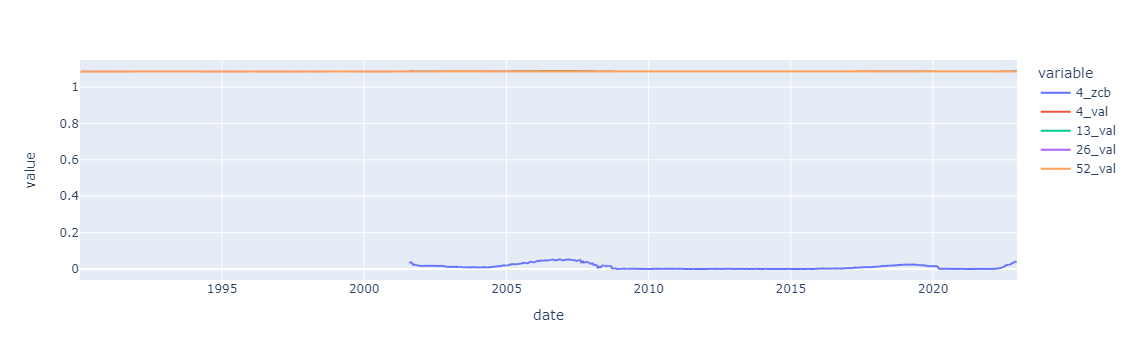

In [52]:
px.line(
    uszcb[[
        '4_zcb',
        '4_val',
        '13_val',
        '26_val',
        '52_val',
    ]],
)

In [15]:
def unstack_zcb_df(in_df):
    df = in_df.copy()
    idx_df = pd.DataFrame(df.columns.str.split('_').tolist(), columns=['tenor', 'figure'])
    idx_df.tenor = idx_df.tenor.astype(float)
    idx_df.replace(0.08, 30/360., inplace=True)
    idx = pd.MultiIndex.from_frame(idx_df)
    df.columns = idx
    df = df.unstack().reorder_levels([1, 2, 0])
    return df

df = unstack_zcb_df(uszcb)
df

figure  date        tenor 
zcb     1990-01-03  4.0            NaN
        1990-01-10  4.0            NaN
        1990-01-17  4.0            NaN
        1990-01-24  4.0            NaN
        1990-01-31  4.0            NaN
                                ...   
val     2022-11-16  1560.0    0.974746
        2022-11-23  1560.0    1.312436
        2022-11-30  1560.0    0.935284
        2022-12-07  1560.0    1.187463
        2022-12-14  1560.0    1.015970
Length: 75416, dtype: float64

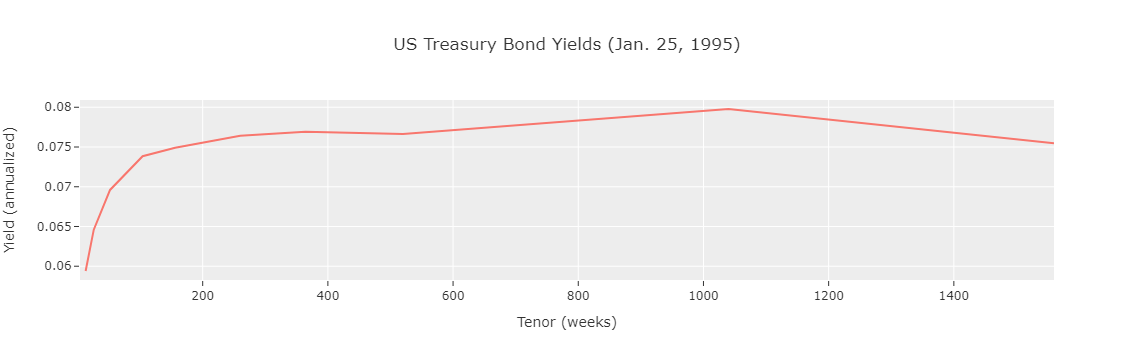

In [24]:
fig = px.line(
    df.loc['zcb', '1995-01-25', slice(None)],
    template=plotly_template,
    labels={
        'value': 'Yield (annualized)',
        'tenor': 'Tenor (weeks)',
    },
    title="US Treasury Bond Yields (Jan. 25, 1995)",
)
fig.update_layout(showlegend=False)
fig

# Strategy 1-A Preliminary Analysis

Mean yield of 1, 3, and 5-year rates:

In [28]:
mean_yield = uszcb[['52_zcb', '156_zcb', '260_zcb']].mean(axis=1)
mean_yield.head(3)

date
1990-01-03    0.078020
1990-01-10    0.077746
1990-01-17    0.079341
dtype: float64

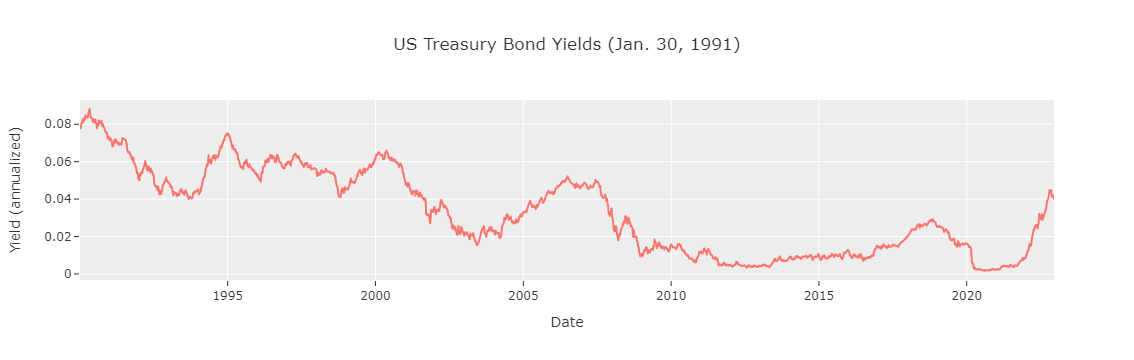

In [30]:
fig = px.line(
    mean_yield,
    template=plotly_template,
    labels={
        'value': 'Yield (annualized)',
        'date': 'Date',
    },
    title="US Treasury Bond Yields (Jan. 30, 1991)",
)
fig.update_layout(showlegend=False)
fig

# Strategy 2-A Preliminary Analysis

This strategy focuses on the mean reversion of the slope of the yield curve over the entire yield curve. For the purposes of this analysis, we examine the spread between the 3 month and 60 month T-notes as a signal for mean-reverting trade opportunities.

In [32]:
spread_360 = (uszcb['260_zcb'] - uszcb['26_zcb'])

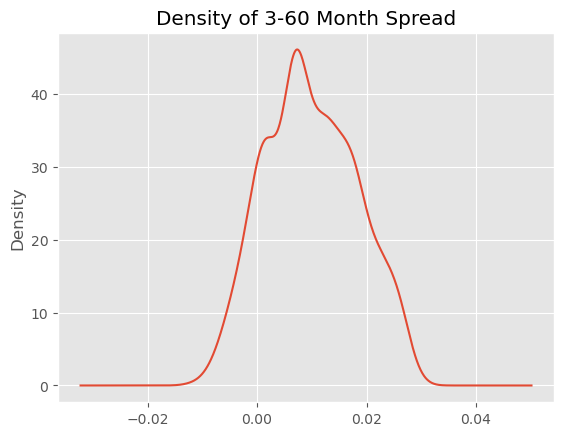

In [33]:
t2 = spread_360.plot(kind='density',xlabel='Spread',title='Density of 3-60 Month Spread')

In [34]:
print('Kurtosis of 3-60 Month Spread Distribution: ',spread_360.kurtosis())
print('Skew of 3-60 Month Spread Distribution: ', spread_360.skew())
sd2 = spread_360.std()*2
print('Proportion of data within 2 standard deviations (assuming Gaussian): ',(sum(spread_360 > (spread_360.mean() + sd2)) + sum(spread_360 < (spread_360.mean()-sd2))) / len(spread_360))

Kurtosis of 3-60 Month Spread Distribution:  -0.7099989393636603
Skew of 3-60 Month Spread Distribution:  0.10653848197592504
Proportion of data within 2 standard deviations (assuming Gaussian):  0.026254375729288213


The distribution of 3-60 month spreads appears to be approximately gaussian with very light tails and no significant skew. The negative kurtosis value indicates at platykurtic distribution, suggesting that the 3-60 month spread is heavily concentrated around the center of the distribution with very few large deviations. For this reason, we must be thoughtful about modeling the spread with light-tailed distributions in order to accurately calculate deviations to trade off of.

Since the trade will be executed by comparing the current yield spread to the spread of the historical curve, we quickly assess the deviations of current spreads from the historical spreads during our desired trading interval.

In [19]:
t = uszcb[['usa_3m_zcb','usa_5y_zcb']]
t['spread'] = t['usa_5y_zcb']- t['usa_3m_zcb']
t['avg_spread']= t['spread'].expanding().mean()

/tmp/ipykernel_19437/3845975508.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_19437/3845975508.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



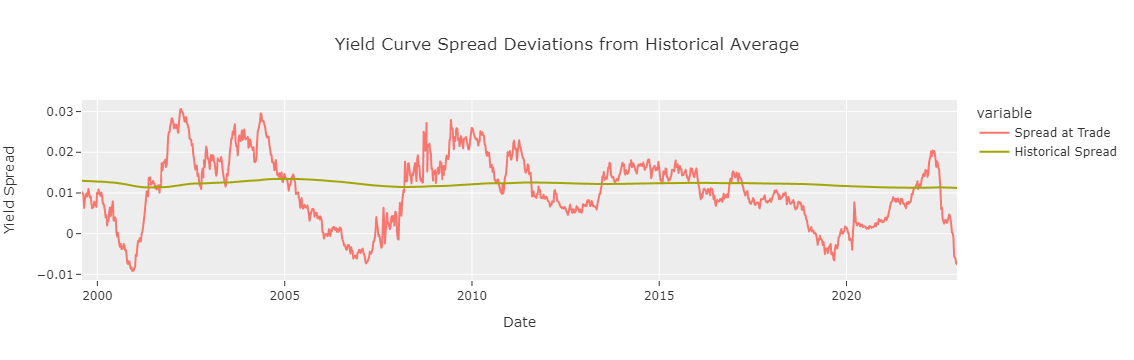

In [20]:
tt = t.drop(columns=['usa_3m_zcb','usa_5y_zcb'])
fig = px.line(
    tt.iloc[500:].rename(columns={
        'spread': 'Spread at Trade',
        'avg_spread': 'Historical Spread',
    }),
    template=plotly_template,
    labels={
        'value': 'Yield Spread',
        'index': 'Date',
    },
    title="Yield Curve Spread Deviations from Historical Average",
)
fig

We verify that there is indeed a mean-reverting trend in the slope, as defined by the 3-60 month spread, to historical levels. In further analysis, we can explore the use of smaller rolling windows to calculate historical averages instead of using the entire date range, in an attempt to produde more trade signals.

# Strategy 3-A Preliminary Analysis

For this strategy, the signal is a significant deviation in the difference between the slopes of two adjacent sections of the yield curve. As an example in our preliminary analysis, we calculate the slope of the curve between 3 and 5-year T-notes, and between 1 and 3-year notes:

In [21]:
slope_35 = (uszcb['usa_5y_zcb'] - uszcb['usa_3y_zcb']) / (5 - 3)
slope_13 = (uszcb['usa_3y_zcb'] - uszcb['usa_1y_zcb']) / (3 - 1)
slope_diff = slope_35 - slope_13
slope_diff.head(3)

1990-01-03    0.000053
1990-01-10   -0.000274
1990-01-17   -0.000183
dtype: float64

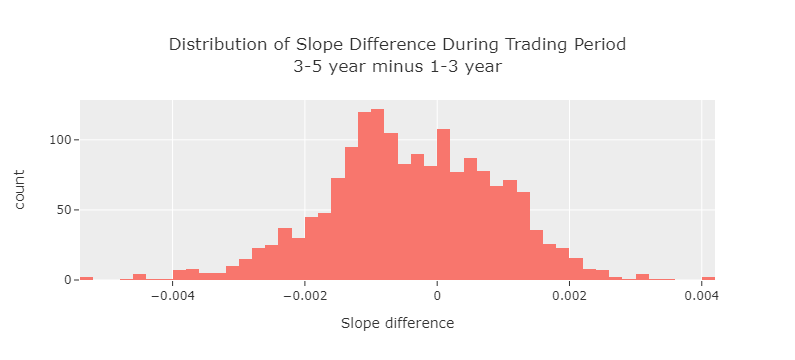

In [22]:
fig = px.histogram(
    slope_diff,
    template=plotly_template,
    labels={
        'count': 'Count',
        'value': 'Slope difference',
    },
    title='Distribution of Slope Difference During Trading Period<br>3-5 year minus 1-3 year',
)
fig.update_layout(showlegend=False)
fig

We can see that the difference in the slopes is roughly Gaussian with fat tails, and skews negative as our intuition would suggest (the 3-5 section of a yield curve usually has a smaller slope than the 1-3 section.

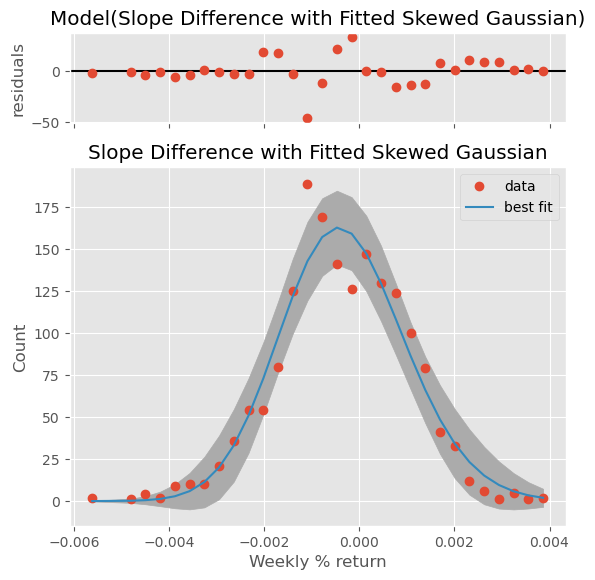

In [23]:
def fit_skewed_gaussian(ser_raw, title='', **kw):
    ser = ser_raw.value_counts(bins=30).sort_index()
    xvals = [idx.mid for idx in ser.index]
    yvals = ser.values
    # print(xvals)
    # print(yvals)
    model = SkewedGaussianModel()
    model.name = title
    params = model.make_params(**kw)
    result = model.fit(yvals, params, x=xvals)
    
    dely = result.eval_uncertainty(sigma=3)
    result.plot(xlabel='Weekly % return', ylabel='Count')
    plt.fill_between(xvals, result.best_fit-dely, result.best_fit+dely, color="#ABABAB",
                     label='3-$\sigma$ uncertainty band')
    plt.title(title)
    return result

result = fit_skewed_gaussian(slope_diff, title='Slope Difference with Fitted Skewed Gaussian')
result

Given this center and standard deviation (we omit $\gamma$ for the sake of simplicity for now), we can determine when in the studied period the slope difference was at least $2\sigma$ from the mean:

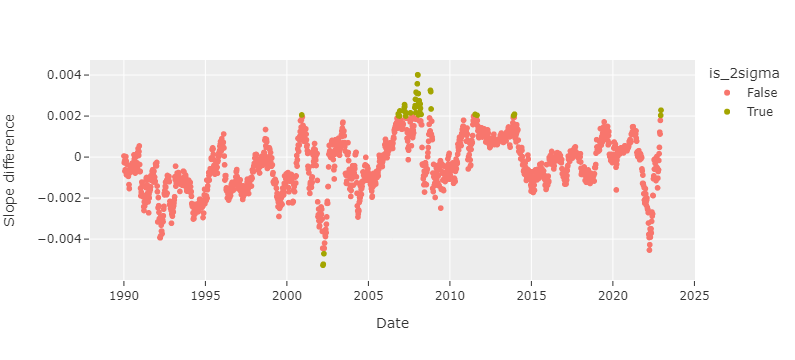

In [24]:
slope_df = slope_diff.to_frame('diff')
slope_df['is_2sigma'] = (slope_df['diff'] - result.params['center'].value).abs() > result.params['sigma'].value * 2
px.scatter(
    slope_df,
    y='diff',
    color='is_2sigma',
    template=plotly_template,
    labels={
        'diff': 'Slope difference',
        'index': 'Date',
    }
)

We noticed that these 2-sigma events in slope difference occur relatively infrequently, which would result in few trading signals. To address this, we plan to decrease (and parametrize) the multiplier in sigma from 2 to 1 or 1.5. In addition, we would determine the standard deviation with respect to the past $N$ periods, instead of the entire timeseries, which would increase signal frequency and eliminate the lookahead bias from using the whole series. This is sufficient for our preliminary analysis, since we can see that the difference in slope appears to mean-revert overall; this is one of the central ideas that motivates our project.

# Scratch